# Passive suicidality in a repressive U.S. political context: Aim I


_WIP - NOT FOR DISTRIBUTION_

_Imports, re-indexes by date, cleans, reduces, restricts by timeframe; permits regex pattern-matched purposive (Wave 1) and random (Wave 2) sampling and named entity redaction of PushShift .gzip Reddit archives for .xlsx annotation. Computes Cohen's Kappa post-annotation. Permits LLM-assisted per-tag triangulation of annotation discrepancies._

> aim_i_annotate_triangulate_iaa.ipynb<br>
> Simone J. Skeen (09-13-2024)

1. [Prepare](xx)
2. [Pre-annotation](xx)
3. [Wave 1 (purposive)](xx)
4. [Wave 2 (random)](xx)
5. [Post-annotation](xx)
6. [Human-LLM triangulation](xx)

### Prepare

In [ ]:
    ### SJS 8/17: recreate using "New Colab" in Drive, reorder logically for GitHub + clean up Fx

In [ ]:
#%%capture

%pip install irrCAC

%pip install openai
%pip install --upgrade openai

%pip install --upgrade pydantic

    ### SJS 8/13: dependency error - fix this

#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.0.0/en_core_web_lg-3.0.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.3/213.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 96.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 2.2.2 which is incompatible.
osqp 0.6.7.p

In [ ]:
#import en_core_web_lg
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
#import openai
import os
import pandas as pd
import random
import re
import spacy
import time
import warnings
import webbrowser

from collections import Counter
from google.colab import drive
from irrCAC.raw import CAC
#from openai import OpenAI
from sklearn.metrics import cohen_kappa_score
from sklearn.utils import shuffle

#spacy.cli.download('en_core_web_lg')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option(
              'display.max_columns',
              None,
              )
pd.set_option(
              'display.max_rows',
              None,
              )

warnings.simplefilter(
                      action = 'ignore',
                      category = FutureWarning,
                      )

#!python -m prodigy stats

In [ ]:
drive.mount(
            '/content/drive',
            #force_remount = True,
            )

Mounted at /content/drive


### Pre-annotation
***

**_Import_**

In [ ]:
wd = '/content/drive/MyDrive/Colab/dissertation/d_posts' ### Colab - gdrive

#wd = 'C:/Users/sskee/OneDrive/Documents/02_tulane/01_research/03_prospectus/d_posts' ### Jupyter - local

ds = []

# loop over .json.gz

for filename in os.listdir(wd):
    if filename.endswith('.json.gz'):
        filepath = os.path.join(
                                wd,
                                filename,
                                )
        with gzip.open(
                       filepath,
                       'rt', ### 'open for reading', 'text mode'
                       encoding = 'utf-8',
                       ) as i:
            data = [json.loads(line) for line in i]
            d_gz = pd.DataFrame(data)
            ds.append(d_gz)

# concatenate

d = pd.concat(
              ds,
              ignore_index = True,
              )

# harmonize

d = d.dropna(
             axis = 1,
             how = 'any',
             )

# de-duplicate

d = d.drop_duplicates(
                      subset = 'id',
                      )

# re-index

d['date'] = pd.to_datetime(
                           d.created_utc,
                           unit = 's',
                           )

d.set_index(
            'date',
            drop = False,
            inplace = True,
            )

# inspect

d.shape
d.dtypes
d.sample(3)

(1459120, 16)

,0
author,object
created_utc,object
edited,object
id,object
is_self,bool
media_embed,object
num_comments,int64
over_18,bool
permalink,object
score,int64


,author,created_utc,edited,id,is_self,media_embed,num_comments,over_18,permalink,score,selftext,subreddit,subreddit_id,thumbnail,title,date
date,,,,,,,,,,,,,,,,
2022-03-11 01:43:06,autisticcatholic,1646962986,False,tbetdi,True,{},1,False,/r/mentalhealth/comments/tbetdi/feeling_stupid...,3,"i have autism, and i am noticing that as i'm g...",mentalhealth,t5_2qirg,self,feeling stupid and childish,2022-03-11 01:43:06
2022-07-15 17:33:15,LaserbeamSharks,1657906395,False,vzud2e,True,{},0,False,/r/SuicideWatch/comments/vzud2e/my_existence_i...,1,,SuicideWatch,t5_2qpzs,self,"MY EXISTENCE IS INHERENTLY SINFUL, WHY DOESN'T...",2022-07-15 17:33:15
2022-03-18 02:03:14,nkkhoinguyen,1647568994,False,tgqila,True,{},0,False,/r/SuicideWatch/comments/tgqila/if_i_am_able_t...,6,,SuicideWatch,t5_2qpzs,self,If I am able to go out because of natural caus...,2022-03-18 02:03:14


**_Format_**

In [ ]:
def prep(d):
    '''Prepares d for annotation'''
    d = d[[
           'author',
           'created_utc',
           'date',
           'id',
           'num_comments',
           'selftext',
           'subreddit',
           'title',
           ]].copy()

    d.rename(
             columns = {
                        'author': 'p_au',
                        'created_utc': 'p_utc',
                        'date': 'p_date',
                        'id': 'p_id',
                        'num_comments': 'n_cmnt',
                        'selftext': 'text',
                        'subreddit': 'sbrt',
                        'title': 'p_titl',
                        }, inplace = True,
            )

    d = d.assign(
                 asp = ' ',      ### STS
                 asp_rtnl = ' ',
                 dep = ' ',
                 dep_rtnl = ' ',
                 val = ' ',
                 val_rtnl = ' ',
                 prg = ' ',      ### explicit
                 tgd = ' ',
                 age = ' ',      ### hybrid
                 race = ' ',     ### implicit
                 dbty = ' ',
                 insb = ' ',     ### insubstantial
                 )

    d = d[~d['text'].isin([
                           '[deleted]',
                           '[removed]',
                           ])]

    return d


(424678, 20)

['SuicideWatch' 'Anxiety' 'depression' 'mentalhealth' 'trans'
 'TheGirlSurvivalGuide' 'TwoXChromosomes']


,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
date,,,,,,,,,,,,,,,,,,,,
2022-03-01,[deleted],1646092800,2022-03-01,t3tuae,1,Anyone else have a corner in their room that ...,SuicideWatch,Corner,,,,,,,,,,,,


,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
date,,,,,,,,,,,,,,,,,,,,
2022-12-30 23:55:55,GnGPanda,1672444555,2022-12-30 23:55:55,zzfkr9,8,I'm quite confused. My (28F) last period was e...,TwoXChromosomes,"Hurting breasts, no period, negative pregnancy...",,,,,,,,,,,,


<Axes: xlabel='date'>

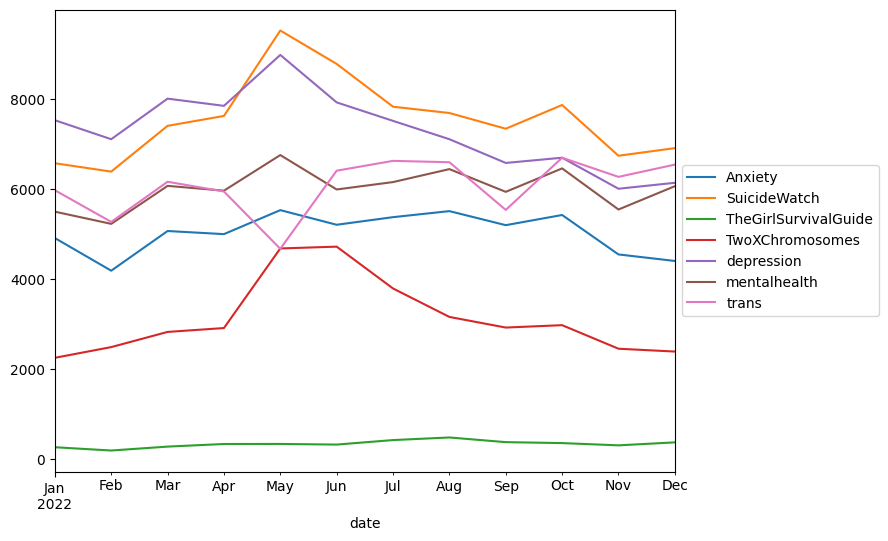

In [ ]:

d = prep(d)

# restrict timeframe

d = d.loc[(d['p_date'] >= '2022-01-01') & (d['p_date'] <= '2022-12-31')]

# verify

d.shape
sbrt = d['sbrt'].unique()
print(sbrt)
d.head(1)
d.tail(1)

# plot

monthly_counts = d.resample('M').sbrt.value_counts().unstack().fillna(0)

fig, ax = plt.subplots(figsize=(10, 6))

monthly_counts.plot(
                    kind = 'line',
                    ax = ax,
                    )

box = ax.get_position()

ax.set_position(
                [
                 box.x0,
                 box.y0,
                 box.width * 0.8,
                 box.height,
                 ]
                  )

ax.legend(
          loc = 'center left',
          bbox_to_anchor=(1, 0.5),
          )

plt.show()

**_Parse by subreddit_**

In [ ]:
def parse(d, col):
    '''Parses d by subreddit'''
    uniq_val = d[col].unique()
    sub_d = {}
    for val in uniq_val:
        sub_d[f'd_{val}'] = d[d[col] == val].copy()

    return sub_d

sub_d = parse(
              d,
              'sbrt',
              )

**_Subset A: strains (proxy)_**

In [ ]:
#d_ax = sub_d['d_Anxiety'] ### deprecated
d_dp = sub_d['d_depression']
#d_mh = sub_d['d_mentalhealth'] ### deprecated
d_sw = sub_d['d_SuicideWatch']

#print('r/Anxiety')
#d_ax.shape
print("\nr/depression")
d_dp.shape
#print("\nr/mentalhealth")
#d_mh.shape
print("\nr/SuicideWatch")
d_sw.shape


r/depression


(87403, 20)


r/SuicideWatch


(90627, 20)

**_Subset B: explicit BAR targets (proxy)_**

In [ ]:
d_gs = sub_d['d_TheGirlSurvivalGuide']
d_tr = sub_d['d_trans']
d_tx = sub_d['d_TwoXChromosomes']

print("r/TheGirlSurvivalGuide")
d_gs.shape
print("\nr/Trans")
d_tr.shape
print("\nr/TwoXChromosomes")
d_tx.shape

r/TheGirlSurvivalGuide


(4032, 20)


r/Trans


(72667, 20)


r/TwoXChromosomes


(37546, 20)

**_ner_redact_post_texts_**

In [ ]:

nlp = spacy.load('en_core_web_lg')

def ner_redact_post_texts(p_text):
    ne = list(
              [
               'PERSON',   ### people, including fictional
               'NORP',     ### nationalities or religious or political groups
               'FAC',      ### buildings, airports, highways, bridges, etc.
               'ORG',      ### companies, agencies, institutions, etc.
               #'GPE',     ### countries, cities, states
               'LOC',      ### non-GPE locations, mountain ranges, bodies of water
               'PRODUCT',  ### objects, vehicles, foods, etc. (not services)
               'EVENT',    ### named hurricanes, battles, wars, sports events, etc.
               ]
                )

    doc = nlp(p_text)
    ne_to_remove = []
    final_string = str(p_text)
    for sent in doc.ents:
        if sent.label_ in ne:
            ne_to_remove.append(str(sent.text))
    for n in range(len(ne_to_remove)):
        final_string = final_string.replace(
                                            ne_to_remove[n],
                                            '<|PII|>',
                                            )
    return final_string

#d['text'] = d['text'].astype(str).apply(lambda i: ner_redact_post_texts(i))

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:749: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


### Wave 1: purposive

#### Cycle 0: pilot (_n_ = 100)

**_r/SuicideWatch_**

In [ ]:
'.gend\S*|pregnan\S*' ### a priori/canonical
'trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe' ### inductively derived

rg = re.compile('.gend\S*|pregnan\S*|trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe', re.I)

d = d.loc[d['text'].str.contains(
                                 rg,
                                 regex = True,
                                 )]

d['text'] = d['text'].astype(str).apply(lambda i: redact(i))
d.shape

# export: 'd_cycle*.xlsx'

os.chdir('C:/Users/sskee/OneDrive/Documents/02_tulane/01_research/03_prospectus/annotation/d_raw')
#%pwd

d.to_excel('d_cycle0.xlsx')

#### Cycle 1 (_n_ = 100)

**Subset A**<br>
r/Anxiety, r/Depression, r/MentalHealth, r/SuicideWatch

**Subset B**<br>
r/Trans

In [ ]:
d_a = pd.concat([
                 d_ax,
                 d_dp,
                 d_mh,
                 d_sw,
                 ])

d_a.reset_index(
                drop = True,
                inplace = True,
                )

d_b = d_tr.copy()

In [ ]:
# subset A: r/anxiety, r/depression, r/mentalhealth, r/SuicideWatch

'.gend\S*|pregnan\S*' ### a priori/canonical
'trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe' ### inductively derived

rg_a = re.compile('.gend\S*|pregnan\S*|trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe', re.I)

d_a = d_a.loc[d_a['text'].str.contains(
                                       rg_a,
                                       regex = True,
                                       )]

d_a.shape

# subset B: r/trans

'.criminal\S*|restrict\S*|.law|.legal\S*' ### a priori/canonical

rg_b = re.compile('.criminal\S*|restrict\S*|.law|.legal\S*', re.I)

d_b = d_b.loc[d_b['text'].str.contains(
                                       rg_b,
                                       regex = True,
                                       )]

d_b.shape

In [ ]:
d = pd.concat([
               d_a, # n = 9740
               d_b, # n = 1505
               ])

d.shape # N = 11245

**Export: 'd_cycle*.xlsx'**

In [ ]:
d = d.sample(n = 100)

d['text'] = d['text'].astype(str).apply(lambda i: redact(i))
d.shape

# export: 'd_cycle*.xlsx'

os.chdir('C:/Users/sskee/OneDrive/Documents/02_tulane/01_research/03_prospectus/annotation/d_raw')
#%pwd

d.to_excel('d_cycle1.xlsx')

####Cycle 2 (_n_ = 100)

**Subset A**<br>
r/Depression, r/SuicideWatch<br>

**Subset B**<br>
r/Trans

In [ ]:
d_a = pd.concat([
                 d_dp,
                 d_sw,
                 ])

        ### SJS 5/22: dropping r/Anxiety, r/mentalhealth

d_a.reset_index(
                drop = True,
                inplace = True,
                )

d_b = d_tr.copy()

In [ ]:
# subset A

'.gend\S*|pregnan\S*' ### a priori/canonical
'trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe' ### inductively derived

rg_a = re.compile('.gend\S*|pregnan\S*|trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe', re.I)

d_a = d_a.loc[d_a['text'].str.contains(
                                       rg_a,
                                       regex = True,
                                       )]

d_a.shape

# subset B

'.criminal\S*|restrict\S*|illegal\S*|outlaw\S*|suicid\S*' ### a priori/canonical

rg_b = re.compile('.criminal\S*|restrict\S*|illegal\S*|outlaw\S*|suicid\S*', re.I)

d_b = d_b.loc[d_b['text'].str.contains(
                                       rg_b,
                                       regex = True,
                                       )]

d_b.shape

In [ ]:
d = pd.concat([
               d_a, # n = 5602
               d_b, # n = 729
               ])

d.shape # N = 11245

**Export: 'd_cycle*.xlsx'**

In [ ]:
d = d.sample(n = 100)

d['text'] = d['text'].astype(str).apply(lambda i: redact(i))

# export: 'd_cycle*.xlsx'

os.chdir('C:/Users/sskee/OneDrive/Documents/02_tulane/01_research/03_prospectus/annotation/d_raw')
#%pwd

d.to_excel('d_cycle2.xlsx')

#### Cycle 3 (_n_ = 150)

**Subset A**<br>
r/Depression, r/SuicideWatch<br>

**Subset B**<br>
r/TheGirlsSurvivalGuide, r/Trans, r/TwoXChromosomes

In [ ]:
d_a = pd.concat([
                 d_dp,
                 d_sw,
                 ])

d_a.reset_index(
                drop = True,
                inplace = True,
                )

d_b = pd.concat([
                 d_gs,
                 d_tr,
                 d_tx,
                 ])

d_b.reset_index(
                drop = True,
                inplace = True,
                )

In [ ]:
# subset A

'.gend\S*|pregnan\S*' ### a priori/canonical
'trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe' ### inductively derived

rg_a = re.compile('.gend\S*|pregnan\S*|trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe', re.I)

d_a = d_a.loc[d_a['text'].str.contains(
                                       rg_a,
                                       regex = True,
                                       )]

d_a.shape

# subset B

'.criminal\S*|restrict\S*|illegal\S*|outlaw\S*|suicid\S*' ### a priori/canonical

rg_b = re.compile('.criminal\S*|restrict\S*|illegal\S*|outlaw\S*|suicid\S*', re.I)

d_b = d_b.loc[d_b['text'].str.contains(
                                       rg_b,
                                       regex = True,
                                       )]

d_b.shape

In [ ]:
d = pd.concat([
               d_a, # n = 5602
               d_b, # n = 1971
               ])

d.shape # N = 7573

**Export: 'd_cycle*.xlsx'**

In [ ]:
d = d.sample(n = 150)

d['text'] = d['text'].astype(str).apply(lambda i: redact(i))

#os.chdir('C:/Users/sskee/OneDrive/Documents/02_tulane/01_research/03_prospectus/annotation/d_raw')
#%pwd

%cd gdrive/My Drive/Colab/prospectus/annotation/d_raw

d.to_excel('d_cycle3.xlsx')

In [ ]:
# random subset - Cycle 999

d_999 = d.sample(n = 1000)

d_999['text'] = d_999['text'].astype(str).apply(lambda i: redact(i))

d_999.to_excel('d_cycle999.xlsx')

#### Cycle 4 (_n_ = 150)

**Supplementing _prg_**

In [ ]:
# inspecting new _prg_ foregrounding subreddits...

    ### SJS 7/15: 2022 for now

%cd /content/gdrive/My Drive/Colab/dissertation/d_posts

d_aw = pd.read_json(
                    #'r_thegirlsurvivalguide_posts.jsonl', # d_gs.xlsx
                    #'r_confession_posts.jsonl', # d_co.xlsx
                    'r_askwomenadvice_posts.jsonl', # d_aw.xlsx
                    #'r_traumatoolbox_posts.jsonl', # d_tb.xlsx
                    #'r_birthcontrol_posts.jsonl', # d_bc.xlsx
                    #'r_WomensHealth_posts.jsonl', # d_wh.xlsx
                    lines = True,
                    )

    ### SJS 7/15: decision: adding r_askwomenadvice to Cycle 4

d_aw.shape
d_aw.head(3)
d_aw.tail(3)

In [ ]:
# harmonize

d_aw = d_aw.dropna(
                   axis = 1,
                   how = 'any',
                   )

# de-duplicate

d_aw = d_aw.drop_duplicates(
                            subset = 'id',
                            )

# re-index

d_aw['date'] = pd.to_datetime(
                              d_aw.created_utc,
                              unit = 's',
                              )

d_aw.set_index(
               'date',
               drop = False,
               inplace = True,
               )

#d.shape
#d.head(3)

d_aw = prep(d_aw)

#d.shape
#d.head(3)

d_aw['text'] = d_aw['text'].astype(str).apply(lambda i: redact(i))
#d_gs['text'] = d_gs['text'].astype(str).apply(lambda i: redact(i))

d_aw.shape
d_aw.head(3)
d_aw.tail(3)

#d_gs.shape
#d_gs.head(3)


In [ ]:
d_dp.shape
d_dp.head(3)
d_sw.shape
d_sw.head(3)

d_gs.shape
d_gs.head(3)
d_tr.shape
d_tr.head(3)
d_tx.shape
d_tx.head(3)

**Subset A: strains**<br>
r/Depression, r/SuicideWatch<br>

**Subset B: explicit targeting**<br>
r/AskWomenAdvice, r/TheGirlsSurvivalGuide, r/Trans, r/TwoXChromosomes

In [ ]:
d_a = pd.concat([
                 d_dp,
                 d_sw,
                 ])

d_a.reset_index(
                drop = True,
                inplace = True,
                )

d_b = pd.concat([
                 d_tr,
                 d_tx,
                 ])

d_b.reset_index(
                drop = True,
                inplace = True,
                )

    ### SJS 7/16: giving an artifical boost to these two (n = 20)

d_c = pd.concat([
                 d_aw,
                 d_gs,
                 ])

d_c.reset_index(
                drop = True,
                inplace = True,
                )


In [ ]:
d_a = shuffle(d_a)
d_a.head(10)
#d_a.sample(10)

In [ ]:
d_b = shuffle(d_b)
d_b.head(10)
#d_b.sample(10)

In [ ]:
d_c = shuffle(d_c)
d_c.head(10)
#d_c.sample(10)

In [ ]:
# subset A

'.gend\S*|pregnan\S*' ### a priori/canonical
'trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe' ### inductively derived

rg_a = re.compile('.gend\S*|pregnan\S*|trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe', re.I)

d_a = d_a.loc[d_a['text'].str.contains(
                                       rg_a,
                                       regex = True,
                                       )]

d_a.shape

# subset B+

'.criminal\S*|restrict\S*|illegal\S*|outlaw\S*|suicid\S*|dobbs|roe|pregnan\S*' ### a priori/canonical

rg_b = re.compile('.criminal\S*|restrict\S*|illegal\S*|outlaw\S*|suicid\S*|dobbs|roe|pregnan\S*', re.I)

d_b = d_b.loc[d_b['text'].str.contains(
                                       rg_b,
                                       regex = True,
                                       )]

d_b.shape

d_c = d_c.loc[d_c['text'].str.contains(
                                       rg_b,
                                       regex = True,
                                       )]

d_c.shape

In [ ]:
d = pd.concat([
               d_a, # n = 5602
               d_b, # n = 5478
               ])

d.shape # N = 11080

**Export: 'd_cycle*.xlsx'**

In [ ]:
d = d.sample(n = 130)

d['text'] = d['text'].astype(str).apply(lambda i: redact(i))


In [ ]:
# supplementing Cycle 4

d_suppl = d_c.sample(n = 20)

d_suppl['text'] = d_suppl['text'].astype(str).apply(lambda i: redact(i))

In [ ]:
# supplementing Cycle 999 (training data)

%cd /content/gdrive/My Drive/Colab/prospectus/annotation/d_raw

d_suppl = d_c.sample(n = 200)
#d_suppl['text'] = d_suppl['text'].astype(str).apply(lambda i: redact(i))
d_suppl.to_excel('d_cycle999_suppl.xlsx')

In [ ]:
d = pd.concat([
               d, # n = 130
               d_suppl, # n = 20
               ])

d.shape # N = xx

In [ ]:
d = shuffle(d)

In [ ]:
%cd /content/gdrive/My Drive/Colab/prospectus/annotation/d_raw

d.to_excel('d_cycle4.xlsx')

### Wave 2: random

In [ ]:
%cd /content/drive/My Drive/Colab/dissertation/d_posts

d_aw = pd.read_excel('d_aw.xlsx')

d_aw.shape
d_aw.head(3)
d_aw.tail(3)

/content/drive/My Drive/Colab/dissertation/d_posts


(256, 21)

,date,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
0,2022-01-01 00:49:00,clickmetoris,1640998140,2022-01-01 00:49:00,rt7lm8,5,I have a boyfriend for 12 years and we've been...,askwomenadvice,Please help me what to do about my situation. ...,,,,,,,,,,,,
1,2022-01-01 12:05:33,thrawyhsp,1641038733,2022-01-01 12:05:33,rti6br,39,It seems much easier doing this in person in p...,askwomenadvice,Do I [21F] meet with my abuser [22M] in public...,,,,,,,,,,,,
2,2022-01-02 03:11:21,nancydrewdidcoke,1641093081,2022-01-02 03:11:21,ru024j,3,"for context, I’m a 21 year old, in college, ho...",askwomenadvice,"I love my family so much, but I feel like they...",,,,,,,,,,,,


,date,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
253,2022-12-29 16:10:59,orphanfunkhousr,1672330259,2022-12-29 16:10:59,zy91dg,3,I have this friend and I just found out that s...,askwomenadvice,My best friend (26f) is pregnant and I don’t w...,,,,,,,,,,,,
254,2022-12-29 19:21:00,Idont-knowdawg,1672341660,2022-12-29 19:21:00,zyds6u,4,hi all so i’m (24f) and recently just got out ...,askwomenadvice,(24f) experiencing pregnancy/scares on nexplan...,,,,,,,,,,,,
255,2022-12-29 23:37:17,MoneyZookeepergame19,1672357037,2022-12-29 23:37:17,zykblu,7,\nOn top of that my husband would look up his ...,askwomenadvice,I’m a 22(F). Been married for 1 year and have ...,,,,,,,,,,,,


In [ ]:
    ### SJS 8/15: same _prg_ oversampling strategy: 1000 random fr d_a and d_b, plus 200 from r/GSG and r/AWA

d_dp.shape
d_dp.head(3)
d_sw.shape
d_sw.head(3)

d_aw.shape
d_aw.head(3)
d_gs.shape
d_gs.head(3)
d_tr.shape
d_tr.head(3)
d_tx.shape
d_tx.head(3)

(87403, 20)

,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
date,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:10:30,Zealousideal-Leek-27,1640995830,2022-01-01 00:10:30,rt6w45,1,I still feel pathetic and like shit all the ti...,depression,All I want to do is graduate high school.,,,,,,,,,,,,
2022-01-01 00:11:34,nosuee,1640995894,2022-01-01 00:11:34,rt6wvx,2,I feel like I haven't accomplished anything th...,depression,New Years.,,,,,,,,,,,,
2022-01-01 00:37:21,withanAnotE,1640997441,2022-01-01 00:37:21,rt7e14,0,since its new years eve and all i looked back ...,depression,i dont feel like theres any escape,,,,,,,,,,,,


(90627, 20)

,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
date,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,[deleted],1646092800,2022-03-01 00:00:00,t3tuae,1,Anyone else have a corner in their room that ...,SuicideWatch,Corner,,,,,,,,,,,,
2022-01-01 00:01:24,jjjkitty,1640995284,2022-01-01 00:01:24,rt6pqc,4,i've devised a list or rules and a plan i will...,SuicideWatch,last day itinerary?,,,,,,,,,,,,
2022-01-01 00:03:01,Hot_Presence_3268,1640995381,2022-01-01 00:03:01,rt6qz5,1,I wish I could die. I am gonna be 22. Never ha...,SuicideWatch,I spent another year all alone. I just want to...,,,,,,,,,,,,


(256, 21)

,date,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
0,2022-01-01 00:49:00,clickmetoris,1640998140,2022-01-01 00:49:00,rt7lm8,5,I have a boyfriend for 12 years and we've been...,askwomenadvice,Please help me what to do about my situation. ...,,,,,,,,,,,,
1,2022-01-01 12:05:33,thrawyhsp,1641038733,2022-01-01 12:05:33,rti6br,39,It seems much easier doing this in person in p...,askwomenadvice,Do I [21F] meet with my abuser [22M] in public...,,,,,,,,,,,,
2,2022-01-02 03:11:21,nancydrewdidcoke,1641093081,2022-01-02 03:11:21,ru024j,3,"for context, I’m a 21 year old, in college, ho...",askwomenadvice,"I love my family so much, but I feel like they...",,,,,,,,,,,,


(4032, 20)

,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
date,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:06:32,BetterRise,1640995592,2022-01-01 00:06:32,rt6tg4,14,I'm not sure if this is the right place for it...,TheGirlSurvivalGuide,"terrified of car repair places, and need a car...",,,,,,,,,,,,
2022-01-01 01:43:40,lifeoflex02,1641001420,2022-01-01 01:43:40,rt8lyx,4,"it never fails, by nightfall every night i sta...",TheGirlSurvivalGuide,does anyone else feel gross by the end of the ...,,,,,,,,,,,,
2022-01-01 02:51:21,ijustatefivekitkats,1641005481,2022-01-01 02:51:21,rt9tje,8,"Hi all,\n\nI'm 25 and I've been talking to a g...",TheGirlSurvivalGuide,Insecure because I have no friends,,,,,,,,,,,,


(72667, 20)

,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
date,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:15:27,britneymassey20,1640996127,2022-01-01 00:15:27,rt6znm,0,,trans,Happy new year,,,,,,,,,,,,
2022-01-01 00:21:33,jellybee_n,1640996493,2022-01-01 00:21:33,rt73va,1,,trans,Euphoria,,,,,,,,,,,,
2022-01-01 00:22:31,Samwhit347,1640996551,2022-01-01 00:22:31,rt74ko,1,,trans,End of 2021,,,,,,,,,,,,


(37546, 20)

,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
date,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:35:20,Prestigious_Pea_825,1640997320,2022-01-01 00:35:20,rt7cvd,0,,TwoXChromosomes,Join the 13-17 T33N L3AKS Discord Server!,,,,,,,,,,,,
2022-01-01 00:42:40,TaintScratcherMaster,1640997760,2022-01-01 00:42:40,rt7hn5,412,Title pretty much says all. Been dealing with ...,TwoXChromosomes,I was asked if I was sure that I knew I was ha...,,,,,,,,,,,,
2022-01-01 00:46:22,tosswhendone_,1640997982,2022-01-01 00:46:22,rt7k0u,1,If you don’t tell a partner about your sexual ...,TwoXChromosomes,Has anyone experienced a partner being upset a...,,,,,,,,,,,,


In [ ]:
d_a = pd.concat([
                 d_dp, ### r/depression
                 d_sw, ### r/SuicideWatch
                 ])

d_a = shuffle(d_a)

d_a.reset_index(
                drop = True,
                inplace = True,
                )

d_b = pd.concat([
                 d_tr, ### r/trans
                 d_tx, ### r/TwoXChromosomes
                 ])

d_b = shuffle(d_b)

d_b.reset_index(
                drop = True,
                inplace = True,
                )

d_c = pd.concat([
                 d_aw, ### r/AskWomenAdvice,
                 d_gs, ### r/TheGirlsSurvivalGuide
                 ])

d_c = shuffle(d_c)

d_c.reset_index(
                drop = True,
                inplace = True,
                )

d_a.shape
d_b.shape
d_c.shape

(178030, 20)

(110213, 20)

(4288, 21)

In [ ]:
d_a.head(3)
d_b.head(3)

#d_c = d_c.drop(
#               'date',
#               axis = 1,
#               )

d_c.head(3)

(178030, 20)

(110213, 20)

(4288, 20)

,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
0,warnbear1990,1666769553,2022-10-26 07:32:33,ydrwj5,5,I’m a 32M and moved over to New Zealand from t...,depression,Everything I want but never happy!,,,,,,,,,,,,
1,Mundane_Leading541,1660085418,2022-08-09 22:50:18,wkh5a7,3,,SuicideWatch,Thinking about killing myself and how I dont h...,,,,,,,,,,,,
2,No_Experience_7115,1650741686,2022-04-23 19:21:26,uacqlv,0,It's hurting to think about how it'll impact f...,SuicideWatch,knowing that there's a schedule for it is comf...,,,,,,,,,,,,


,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
0,Darthfox64x2,1649228625,2022-04-06 07:03:45,txg9mw,0,,trans,y'all are idiots,,,,,,,,,,,,
1,lennyzenith,1650297551,2022-04-18 15:59:11,u6gj4b,2,"Hi. I'm a trans musician, composer, performer ...",trans,I need video for a 'protect trans kids' video ...,,,,,,,,,,,,
2,EvidenceLittle135,1664398729,2022-09-28 20:58:49,xqo7xs,3,So here’s the rundown. I was born as a male bu...,trans,Am I trans or just coping?,,,,,,,,,,,,


,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
0,artisticromantic,1661278709,2022-08-23 18:18:29,wvvycg,5,Hi all! I just turned 21 and am new to going t...,TheGirlSurvivalGuide,What the heck should I be doing annually?,,,,,,,,,,,,
1,Deep-Impact-2871,1657144609,2022-07-06 21:56:49,vt1r7u,0,,TheGirlSurvivalGuide,Why is my leg hair growing so fast? All my lif...,,,,,,,,,,,,
2,shortyshoo,1646833083,2022-03-09 13:38:03,ta7yh3,26,Hello ladies. I'm back on the market after exi...,TheGirlSurvivalGuide,How to stop finding normal dating stuff 'cringe'?,,,,,,,,,,,,


In [ ]:
d = pd.concat([
               d_a, # n = 178030
               d_b, # n = 110213
               ])

d.shape # N = 288243

(288243, 20)

In [ ]:
d = d.sample(n = 1000)

d['text'] = d['text'].astype(str).apply(lambda i: ner_redact_post_texts(i))

d.shape # N = 1000

(1000, 20)

In [ ]:
d_suppl = d_c.sample(n = 200)

d_suppl['text'] = d_suppl['text'].astype(str).apply(lambda i: ner_redact_post_texts(i))

d_suppl.shape # N = 200

(200, 20)

In [ ]:
d = pd.concat([
               d, # n = 1000
               d_suppl, # n = 200
               ])

d.shape # N = 1200

(1200, 20)

In [ ]:
%cd /content/drive/My Drive/Colab/dissertation/annotation/d_raw

d.to_excel('d_cycle999_rnd.xlsx')

/content/drive/My Drive/Colab/dissertation/annotation/d_raw


### Post-annotation
***

**_Import_**

In [ ]:

    ### SJS 7/23: old, but use for pre-negotiation kappa, then define GPT-4o Fx, then split and annotate d_dis etc

    ### SJS 7/23: convention: d_iaa_cycle* for pre-GPT; d_iaa_gpt_cycle* for post-GPT negotiated


%cd /content/drive/My Drive/Colab/bar_policy_suicidality/inputs/annotation

d_sd = pd.read_excel('d_cycle1_sd.xlsx')
#d_sd.dtypes

#d_sd = d_sd.replace(' ', 0)
d_sd.columns = [f'{col}_sd' for col in d_sd.columns]


d_ss = pd.read_excel('d_cycle1_ss.xlsx')
#d_ss.dtypes

#d_ss = d_ss.replace(' ', 0)
d_ss.columns = [f'{col}_ss' for col in d_ss.columns]

# inspect

#d_sd.head(3)
#d_ss.head(3)

# merge

d = pd.merge(
             d_sd,
             d_ss,
             left_index = True,
             right_index = True,
             )

targets = [
           'asp_sd', 'asp_ss',
           'dep_sd', 'dep_ss',
           'val_sd', 'val_ss',
           'prg_sd', 'prg_ss',
           'tgd_sd', 'tgd_ss',
           'age_sd', 'age_ss',
           'race_sd', 'race_ss',
           'dbty_sd', 'dbty_ss',
           'insb_sd', 'insb_ss',
            ]

#d = d[targets].copy()

d[targets] = d[targets].apply(
                              pd.to_numeric,
                              errors = 'coerce',
                              )

d = d.fillna(0)
d = d.replace(' ', 0)
#d = d.apply(pd.to_numeric, errors='coerce')


d = d[[
        #targets,
        'p_id_sd', 'p_id_ss', ### sense-check for bad merge
        'text_sd',
        'asp_sd', 'asp_ss',
        'asp_rtnl_sd', 'asp_rtnl_ss',
        'dep_sd', 'dep_ss',
        'dep_rtnl_sd', 'dep_rtnl_ss',
        'val_sd', 'val_ss',
        'val_rtnl_sd', 'val_rtnl_ss',
        'prg_sd', 'prg_ss',
        'tgd_sd', 'tgd_ss',
        'age_sd', 'age_ss',
        'race_sd', 'race_ss',
        'dbty_sd', 'dbty_ss',
        'insb_sd', 'insb_ss',
        ]].copy()

d.rename(
           columns = {
                      'p_id_sd': 'p_id',
                      'text_sd': 'text',
                      }, inplace = True,
          )

#d.to_excel('iaa_inspect.xlsx')

# drop insb = 1 (either annotator)

#d = d[(d['insb_sd'] != 1) & (d['insb_ss'] != 1)]

# target = 0 for insb = 1 (either annotator)

# condition to check where either 'insb_sd' or 'insb_ss' is 1

condition = (d['insb_sd'] == 1) | (d['insb_ss'] == 1)

# update 'asp', 'dep', and 'val' to 0 where the condition is True

d.loc[condition, ['asp', 'val', 'dep']] = 0


'n valid'
d.shape

# convert to numpy array

#for target in targets:
#    target = d[target].to_numpy()

# kappa Fx

def calculate_kappa(d, col_sd, col_ss):
    return cohen_kappa_score(d[col_sd], d[col_ss])

# initialize SD-SJS col pair list

column_pairs = [
                ('asp_sd', 'asp_ss'),
                ('dep_sd', 'dep_ss'),
                ('val_sd', 'val_ss'),
                #('prg_sd', 'prg_ss'),
                #('tgd_sd', 'tgd_ss'),
                #('age_sd', 'age_ss'),
                #('race_sd', 'race_ss'),
                #('dbty_sd', 'dbty_ss'),
                ]

# initialize dict

kappa_results = {}

# kappa loop

for col_sd, col_ss in column_pairs:
    kappa = calculate_kappa(d, col_sd, col_ss)
    kappa_results[f'{col_sd} and {col_ss}'] = kappa

for pair, kappa in kappa_results.items():
    print(f"Cohen's Kappa for {pair}: {kappa:.2f}")


# dummy disagreement Fx

def d_disagree(row):
    return 1 if row[0] != row[1] else 0

sts_pairs = [('asp_sd', 'asp_ss', 'asp_dis'),
             ('dep_sd', 'dep_ss', 'dep_dis'),
             ('val_sd', 'val_ss', 'val_dis')]

for col1, col2, dis_col in sts_pairs:
    d[dis_col] = d[[col1, col2]].apply(d_disagree, axis = 1)

#d.to_excel('iaa_cycle3.xlsx')

IndentationError: expected an indented block after 'for' statement on line 132 (<ipython-input-9-338bef96e1a3>, line 133)

In [ ]:
%cd /content/drive/My Drive/Colab/bar_policy_suicidality/inputs/annotation

d_sd = pd.read_excel('d_cycle4_sd.xlsx')
# d_sd.dtypes

# d_sd = d_sd.replace(' ', 0)
d_sd.columns = [f'{col}_sd' for col in d_sd.columns]

d_ss = pd.read_excel('d_cycle4_ss.xlsx')
# d_ss.dtypes

# d_ss = d_ss.replace(' ', 0)
d_ss.columns = [f'{col}_ss' for col in d_ss.columns]

# inspect

# d_sd.head(3)
# d_ss.head(3)

# merge

d = pd.merge(
    d_sd,
    d_ss,
    left_index=True,
    right_index=True,
)

targets = [
    'asp_sd', 'asp_ss',
    'dep_sd', 'dep_ss',
    'val_sd', 'val_ss',
    'prg_sd', 'prg_ss',
    'tgd_sd', 'tgd_ss',
    'age_sd', 'age_ss',
    'race_sd', 'race_ss',
    'dbty_sd', 'dbty_ss',
    'insb_sd', 'insb_ss',
]

# d = d[targets].copy()

d[targets] = d[targets].apply(
    pd.to_numeric,
    errors='coerce',
)

d = d.fillna(0)
d = d.replace(' ', 0)
# d = d.apply(pd.to_numeric, errors='coerce')

d = d[[
    # targets,
    'p_id_sd', 'p_id_ss',  # sense-check for bad merge
    'text_sd',
    'asp_sd', 'asp_ss',
    'asp_rtnl_sd', 'asp_rtnl_ss',
    'dep_sd', 'dep_ss',
    'dep_rtnl_sd', 'dep_rtnl_ss',
    'val_sd', 'val_ss',
    'val_rtnl_sd', 'val_rtnl_ss',
    'prg_sd', 'prg_ss',
    'tgd_sd', 'tgd_ss',
    'age_sd', 'age_ss',
    'race_sd', 'race_ss',
    'dbty_sd', 'dbty_ss',
    'insb_sd', 'insb_ss',
]].copy()

d.rename(
    columns={
        'p_id_sd': 'p_id',
        'text_sd': 'text',
    }, inplace=True,
)

# d.to_excel('iaa_inspect.xlsx')

# drop insb = 1 (either annotator)

# d = d[(d['insb_sd'] != 1) & (d['insb_ss'] != 1)]

# target = 0 for insb = 1 (either annotator)

condition = (d['insb_sd'] == 1) | (d['insb_ss'] == 1)

# update 'asp', 'dep', and 'val' to 0 where insb = 1 (either annotator)

d.loc[condition, ['asp', 'val', 'dep']] = 0

'n valid'
d.shape

# to numpy

# for target in targets:
#     target = d[target].to_numpy()

# kappa Fx

def calculate_kappa(d, col_sd, col_ss):
    return cohen_kappa_score(d[col_sd], d[col_ss])

# initialize SD-SJS col pair list

column_pairs = [
    ('asp_sd', 'asp_ss'),
    ('dep_sd', 'dep_ss'),
    ('val_sd', 'val_ss'),
    # ('prg_sd', 'prg_ss'),
    # ('tgd_sd', 'tgd_ss'),
    # ('age_sd', 'age_ss'),
    # ('race_sd', 'race_ss'),
    # ('dbty_sd', 'dbty_ss'),
]

# initialize dict

kappa_results = {}

# kappa loop

for col_sd, col_ss in column_pairs:
    kappa = calculate_kappa(d, col_sd, col_ss)
    kappa_results[f'{col_sd} and {col_ss}'] = kappa

for pair, kappa in kappa_results.items():
    print(f"Cohen's Kappa for {pair}: {kappa:.2f}")


# dummy disagreement Fx

def d_disagree(row):
    return 1 if row[0] != row[1] else 0

sts_pairs = [('asp_sd', 'asp_ss', 'asp_dis'),
             #('dep_sd', 'dep_ss', 'dep_dis'),
             ('val_sd', 'val_ss', 'val_dis')]

for col1, col2, dis_col in sts_pairs:
    d[dis_col] = d[[col1, col2]].apply(d_disagree, axis=1)

# d.to_excel('iaa_cycle3.xlsx')

/content/drive/My Drive/Colab/suicidality_repressive_policy/inputs/annotation


'n valid'

(150, 30)

Cohen's Kappa for asp_sd and asp_ss: 0.37
Cohen's Kappa for dep_sd and dep_ss: 0.46
Cohen's Kappa for val_sd and val_ss: 0.36


### Human-LLM triangulation

**_Formulate 'asp' prompt_**

In [ ]:
role = '''
You are tasked with applying qualitative codes to social media posts to categorize whether each post contains an expression of _aspiration strain_.
'''

definition = '''
Definition of aspiration strain: 'any description of ambition, futurity, idealized or speculative lifecourse trajectories, or personal,
professional, familial goals driving psychological strain and/or self-destructive cognitions.' Descriptions can be explicit or implicit.
'''

instruction = '''
Below I instruct on how to apply the codes.

Respond with 'asp_1' if the post contains an expression of aspiration strain, and '0' if it does not.

You must choose a 'asp_1' or a '0' response.

If your response is 'asp_1,' then begin a new paragraph with 'asp_rationale' and excerpt the sentences or phrases that are the _most expressive of
aspiration strain_. You are allowed to choose multiple sentences or phrases, divided by an '<SPL>' token.

If your response is 'asp_1,' then begin a new paragraph with 'strained aspirations:' and concisely name the strained aspiration that is driving the distressful
cognitions.

Then, whether you have selected a 'asp_1' or a '0,' begin a new paragraph with 'asp_explanation:' and provide a two sentence explanation for your response.
'''

clarification = '''
Here are additional clarifying points based in human expertise:
-	Regret over, or wishing to redo, a past decision does _not_ warrant a 'asp_1' response
-	Aspiration for physical impossibility (time travel, age reversion), does not warrant a 'asp_1' response
-	Sparse decontextualized expressions of loneliness (e.g. 'I am lonely') do not warrant a 'asp_1' response; recognition of need or yearning for
friendship, community, and/or intimacy must be explicit to warrant a 'asp_1' response
-	Sparse decontextualized desire for a different assigned sex at birth does not warrant a 'asp_1' response; desire for gender transition or
gender-expansive expression must be explicit.
- Perceived inability to die by suicide does not warrant a 'asp_1' response
'''

asp_prompt = f'{role}{definition}{instruction}{clarification}'
#print(prompt)

**_Formulate 'val' prompt_**

In [ ]:
role = '''
You are tasked with applying qualitative codes to social media posts to categorize whether each post contains an expression of _value strain_.
'''

definition = '''
Definition of aspiration strain: 'any description of conflicting ideologies, norms, mores, morals, ethics, principles, or ontologies, particularly
along traditionalist-authoritarian versus progressive-liberatory axes, driving intra-psychic strain and/or self-destructive cognitions..' Descriptions
can be explicit or implicit.
'''

instruction = '''
Below I instruct on how to apply the codes.

Respond with 'val_1' if the post contains an expression of value strain, and '0' if it does not.

You must choose a 'val_1' or a '0' response.

If your response is 'val_1,' then begin a new paragraph with 'val_rationale:' and excerpt the sentences or phrases that are the _most expressive of
value strain_. You are allowed to choose multiple sentences or phrases, divided by an '<SPL>' token.

If your response is 'val_1,' then begin a new paragraph with 'strained values:' and concisely name the strained value that is driving the distressful
cognitions.

Then, whether you have selected a 'val_1' or a '0,' begin a new paragraph with 'val_explanation:' and provide a two sentence explanation for your response.
'''

clarification = '''
Here are additional clarifying points based in human expertise:
-	a 'val_1' response refer to interpersonal ideological discord and/or internalized ideologically determined self-denigration
-	Anticipated value strain does warrant a 'val_1' response
-	Familial conflict alone is insufficient to warrant a 'val_1' response
-	Perceived failure to uphold self-imposed expectations is insufficient to warrant a 'val_1' response
-	Stress or tension over legality of decisions, necessities does warrant a 'val_1' response
-	ideological or normative aspect must be explicit
'''

val_prompt = f'{role}{definition}{instruction}{clarification}'
#print(prompt)

**_Define function_**

In [ ]:
api_key = '<api_key>' ### project = skeen_prospectus; name = annotate
client = OpenAI(api_key = api_key)

def annotate_post_per_tag(text):
    '''
    Applies an annotation decision, based on pre-specified prompt 'prompt', to a given text 'text'; provides rationale and explanation.
    '''
    try:
        response = client.chat.completions.create(
                                                  model = 'gpt-4o', ### https://platform.openai.com/docs/models
                                                  temperature = 0.2,
                                                  messages = [
                                                              {
                                                               'role': 'system',
                                                               'content': f'{asp_prompt}{val_prompt}' ### double up prompts?
                                                               },
                                                              {
                                                               'role': 'user',
                                                               'content': f'{text}'
                                                               },
                                                            ]
                                                  )
        result = ' '
        for choice in response.choices:
            result += choice.message.content
        print(f'{text}: {result}')
        return result
    except Exception as e:
        print(f'Exception: {e}')
        return 'error'

**annotate_post_per_tag**

In [ ]:
text = '''
All my life I wished I could be a champion snowboarder, but my injuries as a child ruined that dream.
Because I am medicated and rely on a walker to navigate only short distances, my athletic career can
never return. I feel hopeless and stunted and passed by, and like a burden to my family.

They maintain strict conservative ideals and are very traditional. I'm more forward-looking and accepting,
and for this too they make me feel like an outcast.
'''
annotate_post_per_tag(text)

In [ ]:
text = '''
I am a sick man.... I am a spiteful man. I am an unattractive man. I believe my liver is diseased.
However, I know nothing at all about my disease, and do not know for certain what ails me.
I don’t consult a doctor for it, and never have, though I have a respect for medicine and doctors.
Besides, I am extremely superstitious, sufficiently so to respect medicine, anyway (I am well-educated
enough not to be superstitious, but I am superstitious). No, I refuse to consult a doctor from spite.
That you probably will not understand. Well, I understand it, though. Of course, I can’t explain who
it is precisely that I am mortifying in this case by my spite: I am perfectly well aware that I cannot
“pay out” the doctors by not consulting them; I know better than anyone that by all this I am only
injuring myself and no one else. But still, if I don’t consult a doctor it is from spite. My liver is
bad, well—let it get worse!
'''
annotate_post_per_tag(text)

**annotate_dataframe_per_tag**

In [ ]:

#api_key = '<api_key>' ### project = skeen_prospectus; name = annotate
#client = OpenAI(api_key = api_key)

#def annotate_dataframe_per_tag(d):
#    '''
#    Applies annotate_post_per_tag to each row in dataframe 'd'.
#    '''
#    for index, row in d.iterrows():
#        result = annotate_post_per_tag(row['text'])
#        if result == 'error':
#            continue

    ### SJS 7/23: good snippet; keep for now

#        asp, rationale, strain, explanation = None, None, None, None

#        if '1' in result:
#            asp = 1
#            rationale = result.split('rationale:')[1].split('strain:')[0].strip() if 'rationale:' in result else None
#            strain = result.split('strain:')[1].split('explanation:')[0].strip() if 'strain:' in result else None
#        else:
#            asp = 0

#        explanation = result.split('explanation:')[1].strip() if 'explanation:' in result else None

#        d.at[index, 'asp_gpt'] = asp
#        d.at[index, 'asp_rtnl_gpt'] = rationale
#        d.at[index, 'asp_strn_gpt'] = strain
#        d.at[index, 'expl_gpt'] = explanation

        # delay between API calls
#        time.sleep(1)

#    return d


In [ ]:

api_key = '<api_key>'  # project = skeen_prospectus; name = annotate
client = OpenAI(api_key=api_key)

def annotate_post_per_tag(text):
    '''
    Applies an annotation decision, based on pre-specified prompt 'prompt', to a given text 'text'; provides rationale and explanation.
    '''
    try:
        response = client.chat.completions.create(
                                                  model = 'gpt-4o', ### https://platform.openai.com/docs/models
                                                  temperature = 0.2,
                                                  messages = [
                                                              {
                                                               'role': 'system',
                                                               'content': f'{asp_prompt}{val_prompt}' ### double up prompts?
                                                               },
                                                              {
                                                               'role': 'user',
                                                               'content': f'{text}'
                                                               },
                                                            ]
                                                  )
        result = ' '
        for choice in response.choices:
            result += choice.message.content
        print(f'{text}: {result}')
        return result
    except Exception as e:
        print(f'Exception: {e}')
        return 'error'
    pass

def annotate_dataframe_per_tag(d):
    '''
    Applies annotate_post_per_tag for aspiration and value strains to each row in dataframe 'd'.
    '''
    for index, row in d.iterrows():
        result = annotate_post_per_tag(row['text'])
        if result == 'error':
            continue

        # 'asp'

        asp, asp_rationale, asp_strain, asp_explanation = None, None, None, None

        if 'asp_1' in result:
            asp = 1
            asp_rationale = result.split('asp_rationale:')[1].split('strained aspirations:')[0].strip() if 'asp_rationale:' in result else None
            asp_strain = result.split('strained aspirations:')[1].split('asp_explanation:')[0].strip() if 'strained aspirations:' in result else None
            asp_explanation = result.split('asp_explanation:')[1].split('val_rationale:')[0].strip() if 'asp_explanation:' in result else None
        else:
            asp = 0

        d.at[index, 'asp_gpt'] = asp
        d.at[index, 'asp_rtnl_gpt'] = asp_rationale
        d.at[index, 'asp_strn_gpt'] = asp_strain
        d.at[index, 'asp_expl_gpt'] = asp_explanation

        # delay between API calls

        time.sleep(1)

        # 'val'

        val, val_rationale, val_strain, val_explanation = None, None, None, None

        if 'val_1' in result:
            val = 1
            val_rationale = result.split('val_rationale:')[1].split('strained values:')[0].strip() if 'val_rationale:' in result else None
            val_strain = result.split('strained values:')[1].split('val_explanation:')[0].strip() if 'strained values:' in result else None
            val_explanation = result.split('val_explanation:')[1].strip() if 'val_explanation:' in result else None
        else:
            val = 0

        d.at[index, 'val_gpt'] = val
        d.at[index, 'val_rtnl_gpt'] = val_rationale
        d.at[index, 'val_strn_gpt'] = val_strain
        d.at[index, 'val_expl_gpt'] = val_explanation

        # delay between API calls

        time.sleep(1)

    return d


In [ ]:
%cd /content/gdrive/My Drive/Colab/prospectus/annotation/gpt_triangulation_pilot

d_test = pd.read_excel('test.xlsx')
d_test.head(3)

In [ ]:
d_test = annotate_dataframe_per_tag(d_test)
d_test.head(3)

#### Cycle 3 LLM triangulation: pilot

In [ ]:
%cd /content/gdrive/My Drive/Colab/prospectus/annotation/llm_triangulation

d = pd.read_excel('iaa_cycle3.xlsx')

# focus on asp for pilot...

    ### SJS 7/15: reset index - later

d = d[[
       'p_id',
       'text',
       'asp_sd',
       'asp_ss',
       'asp_rtnl_sd',
       'asp_rtnl_ss',
       ]].copy()

d.shape
d.head(3)

In [ ]:
# triangulate Cycle 3

d = annotate_dataframe_per_tag(d)
#print(d)
d.head(3)


In [ ]:
d.to_excel('iaa-gpt_cycle3.xlsx')

#### Cycle 4 LLM triangulation: _asp_ and _val_

In [ ]:
%pwd

'/content'

In [ ]:
%cd /content/drive/My Drive/Colab/bar_policy_suicidality/inputs/annotation

d_sd = pd.read_excel('d_cycle4_sd.xlsx')
#d_sd.dtypes

#d_sd = d_sd.replace(' ', 0)
d_sd.columns = [f'{col}_sd' for col in d_sd.columns]


d_ss = pd.read_excel('d_cycle4_ss.xlsx')
#d_ss.dtypes

#d_ss = d_ss.replace(' ', 0)
d_ss.columns = [f'{col}_ss' for col in d_ss.columns]


# inspect

#d_sd.head(3)
#d_ss.head(3)

# merge

d = pd.merge(
             d_sd,
             d_ss,
             left_index = True,
             right_index = True,
             )

targets = [
           'asp_sd', 'asp_ss',
           'dep_sd', 'dep_ss',
           'val_sd', 'val_ss',
           'prg_sd', 'prg_ss',
           'tgd_sd', 'tgd_ss',
           'age_sd', 'age_ss',
           'race_sd', 'race_ss',
           'dbty_sd', 'dbty_ss',
           'insb_sd', 'insb_ss',
            ]

#d = d[targets].copy()

d[targets] = d[targets].apply(
                              pd.to_numeric,
                              errors = 'coerce',
                              )

d = d.fillna(0)
d = d.replace(' ', 0)
#d = d.apply(pd.to_numeric, errors='coerce')


d = d[[
        #targets,
        'p_id_sd', 'p_id_ss', ### sense-check for bad merge
        'text_sd',
        'asp_sd', 'asp_ss',
        'asp_rtnl_sd', 'asp_rtnl_ss',
        'asp_strn_sd', 'asp_strn_ss', ### added _strn 'name the aspiration'
        'dep_sd', 'dep_ss',
        'dep_rtnl_sd', 'dep_rtnl_ss',
        'val_sd', 'val_ss',
        'val_rtnl_sd', 'val_rtnl_ss',
        'val_strn_sd', 'val_strn_ss', ### added _strn 'name the value'
        'prg_sd', 'prg_ss',
        'tgd_sd', 'tgd_ss',
        'age_sd', 'age_ss',
        'race_sd', 'race_ss',
        'dbty_sd', 'dbty_ss',
        'insb_sd', 'insb_ss',
        ]].copy()

d.rename(
           columns = {
                      'p_id_sd': 'p_id',
                      'text_sd': 'text',
                      }, inplace = True,
          )

#d.to_excel('iaa_inspect.xlsx')

# drop insb = 1 (either annotator)

#d = d[(d['insb_sd'] != 1) & (d['insb_ss'] != 1)]

# target = 0 for insb = 1 (either annotator)

# check: 'insb_sd' or 'insb_ss' is 1

condition = (d['insb_sd'] == 1) | (d['insb_ss'] == 1)

# 'asp', 'dep', and 'val' = 0 where 'insb' = True

d.loc[condition, ['asp', 'val', 'dep']] = 0


'n valid'
d.shape

# to numpy

#for target in targets:
#    target = d[target].to_numpy()

# kappa Fx

def calculate_kappa(d, col_sd, col_ss):
    return cohen_kappa_score(d[col_sd], d[col_ss])

column_pairs = [
                ('asp_sd', 'asp_ss'),
                ('dep_sd', 'dep_ss'),
                ('val_sd', 'val_ss'),
                #('prg_sd', 'prg_ss'),
                #('tgd_sd', 'tgd_ss'),
                #('age_sd', 'age_ss'),
                #('race_sd', 'race_ss'),
                #('dbty_sd', 'dbty_ss'),
                ]

kappa_results = {}

for col_sd, col_ss in column_pairs:
    kappa = calculate_kappa(d, col_sd, col_ss)
    kappa_results[f'{col_sd} and {col_ss}'] = kappa

for pair, kappa in kappa_results.items():
    print(f"Cohen's Kappa for {pair}: {kappa:.2f}")


# disagreement Fx

def d_disagree(row):
    return 1 if row[0] != row[1] else 0

sts_pairs = [('asp_sd', 'asp_ss', 'asp_dis'),
             ('dep_sd', 'dep_ss', 'dep_dis'),
             ('val_sd', 'val_ss', 'val_dis')]

for col1, col2, dis_col in sts_pairs:
    d[dis_col] = d[[col1, col2]].apply(d_disagree, axis = 1)

#d.to_excel('iaa_cycle3.xlsx')
#d.dtypes
#d.head(3)

/content/drive/My Drive/Colab/suicidality_repressive_policy/inputs/annotation


KeyError: "['asp_strn_sd', 'asp_strn_ss', 'val_strn_sd', 'val_strn_ss'] not in index"

In [ ]:
#d.shape
#d.dtypes
#d.head(3)

In [ ]:

# df for SJS-SD disagreements

d_dis = d[(d['asp_dis'] == 1) | (d['val_dis'] == 1)]
d_dis.shape

# drop disagreements fr orig df

d_agr = d[~((d['asp_dis'] == 1) | (d['val_dis'] == 1))]
d_agr.shape

# GPT-4o - asp

d_dis = annotate_dataframe_per_tag(d_dis)

# append d_dis to d_agr

d_iaa_gpt_cycle4 = pd.concat(
                             [
                              d_dis,
                              d_agr,
                              ], ignore_index = True,
                             )

# prioritize GPT-4o-annotated rows for human inspection

d_iaa_gpt_cycle4 = d_iaa_gpt_cycle4.sort_values(
                                                by = [
                                                      'asp_dis',
                                                      'val_dis',
                                                      ], ascending = False
                                                ).reset_index(drop = True)

d_iaa_gpt_cycle4.head(3)

In [ ]:
# sort cols for human readability + add 'notes'

d_iaa_gpt_cycle4['notes_for_asp'] = ' '
d_iaa_gpt_cycle4['notes_for_val'] = ' '

d_iaa_gpt_cycle4 = d_iaa_gpt_cycle4[[
                                     'text',
                                     'asp_sd',
                                     'asp_ss',
                                     'asp_gpt',
                                     'asp_rtnl_sd',
                                     'asp_rtnl_ss',
                                     'asp_rtnl_gpt',
                                     'asp_strn_sd',
                                     'asp_strn_ss',
                                     'asp_strn_gpt',
                                     'asp_expl_gpt',
                                     'asp_dis',
                                     'notes_for_asp',

                                     'text',
                                     'val_sd',
                                     'val_ss',
                                     'val_gpt',
                                     'val_rtnl_sd',
                                     'val_rtnl_ss',
                                     'val_rtnl_gpt',
                                     'val_strn_sd',
                                     'val_strn_ss',
                                     'val_strn_gpt',
                                     'val_expl_gpt',
                                     'val_dis',
                                     'notes_for_val',
                                     ]].copy()

d_iaa_gpt_cycle4.shape
d_iaa_gpt_cycle4.head(3)

In [ ]:
d_iaa_gpt_cycle4.to_excel('d_iaa_gpt_cycle4.xlsx')

#### Cycle 4: Post-LLM triangulation: _asp_ and _val_

In [ ]:
%cd /content/drive/My Drive/Colab/dissertation/annotation

d = pd.read_excel('d_iaa_gpt_cycle4_sd-ss.xlsx')

def calculate_kappa(d, col_sd, col_ss):
    return cohen_kappa_score(d[col_sd], d[col_ss])

# cols: SJS-SD

column_pairs = [
                ('asp_sd', 'asp_ss'),
                ('val_sd', 'val_ss'),
                ]

kappa_results = {}

for col_sd, col_ss in column_pairs:
    kappa = calculate_kappa(d, col_sd, col_ss)
    kappa_results[f'{col_sd} and {col_ss}'] = kappa

for pair, kappa in kappa_results.items():
    print(f"Cohen's Kappa for {pair}: {kappa:.2f}")


/content/drive/My Drive/Colab/dissertation/annotation
Cohen's Kappa for asp_sd and asp_ss: 0.96
Cohen's Kappa for val_sd and val_ss: 0.97


### Viz

In [ ]:
%cd /content/drive/My Drive/Colab/bar_policy_suicidality/outputs/tables

d_v = pd.read_excel('d_cycle_kappas.xlsx')

/content/drive/My Drive/Colab/suicidality_repressive_policy/outputs/tables


[Errno 2] No such file or directory: '.../figures'
/content/drive/My Drive/Colab/suicidality_repressive_policy/outputs/tables


<Figure size 800x600 with 0 Axes>

Text(0, 0.5, "Cohen's $\\kappa$")

([<matplotlib.axis.XTick at 0x7ad65dc9d0f0>,
 [Text(1, 0, 'cycle 1'),
  Text(2, 0, 'cycle 2'),
  Text(3, 0, 'cycle 3'),
  Text(4, 0, 'pre-GTP: cycle 4'),
  Text(5, 0, 'post-GPT: cycle 4')])

(0.0, 1.0115)

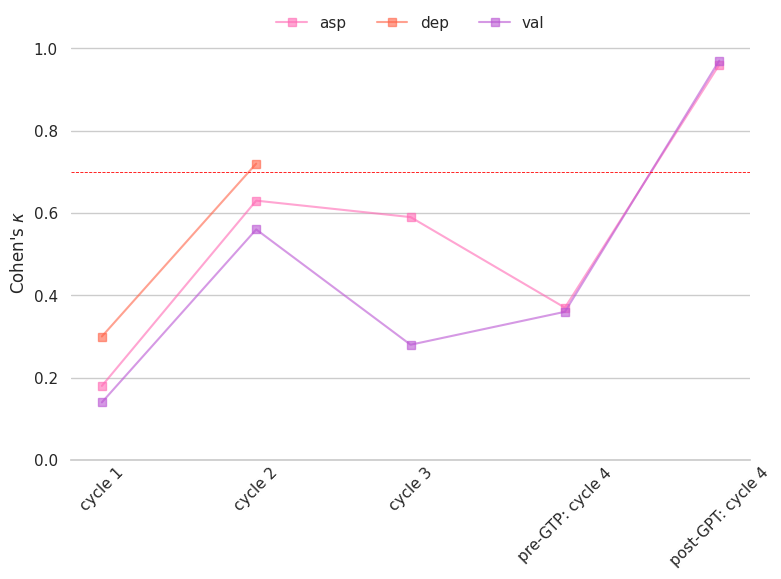

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%cd .../figures

sns.set(style = 'whitegrid')

# custom x-axis labels

custom_labels = [
                 'cycle 1',
                 'cycle 2',
                 'cycle 3',
                 'pre-GTP: cycle 4',
                 'post-GPT: cycle 4',
                 ]

# plot

plt.figure(figsize = (
                      8,
                      6,
                      )
          )

plt.plot(
         d_v['cycle'],
         d_v['asp_cohens_k'],
         label = "asp",
         marker = 's',
         alpha = 0.6,
         color = 'hotpink',
         )

plt.plot(
         d_v['cycle'],
         d_v['dep_cohens_k'],
         label = "dep",
         marker = 's',
         alpha = 0.6,
         color = 'tomato',
         )

plt.plot(
         d_v['cycle'],
         d_v['val_cohens_k'],
         label = "val",
         marker = 's',
         alpha = 0.6,
         color = 'mediumorchid',
         )

# labels, title

#plt.xlabel('Cycle')
plt.ylabel("Cohen's $\kappa$")
#plt.title("Cohen's $\kappa$ Value per Cycle for ASP, DEP, and VAL")

# custom x-axis labels, 45-degree angle

plt.xticks(
           ticks = d_v['cycle'],
           labels=custom_labels,
           rotation = 45,
           )



# horizontal gridlines

plt.grid(axis='x')

# set line at 0.7 threshold

plt.axhline(
            y = 0.7,
            color = 'red',
            linewidth = 0.6,
            linestyle = '--',
            )

# x-axis at 0

plt.ylim(
         0,
         None,
         )

# legend

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, frameon=False)

# x-axis ticks

plt.gca().tick_params(axis='x', which='both', direction='in', length=5)  # Adds ticks to the x-axis labels

# optimized markers

#x0 = [2, 5, 5]
#y0 = [0.72, 0.96, 0.97]
#plt.plot(x0, y0, "s", markersize = 7, color = 'red')

#for a,b in zip(x0, y0):
#    plt.text(a, b, str(b),fontsize=9, ha='right',va='top')

sns.despine(
            left = True,
            )

# tight layout

plt.tight_layout()

# save

plt.savefig('cycle_kappa_line.png')

# display

plt.show()


> End of bar_sample_annotate_iaa.ipynb